In [87]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from statsmodels.tsa.arima.model import ARIMA 
from tqdm import tqdm
import joblib
import copy

import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Инжиниринг признаков производится аналогично Multi-Class Classification.

In [42]:
# # Загрузка всех таблиц
# telemetry = pd.read_csv(r"C:\Users\valekseeva\Documents\Project\Hybrid-Predictive-Maintenance\Datasets\PdM_telemetry.csv")
# errors = pd.read_csv(r"C:\Users\valekseeva\Documents\Project\Hybrid-Predictive-Maintenance\Datasets\PdM_errors.csv")
# maint = pd.read_csv(r"C:\Users\valekseeva\Documents\Project\Hybrid-Predictive-Maintenance\Datasets\PdM_maint.csv")
# failures = pd.read_csv(r"C:\Users\valekseeva\Documents\Project\Hybrid-Predictive-Maintenance\Datasets\PdM_failures.csv")
# machines = pd.read_csv(r"C:\Users\valekseeva\Documents\Project\Hybrid-Predictive-Maintenance\Datasets\PdM_machines.csv")

In [43]:
# Загрузка всех таблиц
telemetry = pd.read_csv("/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Datasets/PdM_telemetry.csv")
errors = pd.read_csv("/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Datasets/PdM_errors.csv")
maint = pd.read_csv("/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Datasets/PdM_maint.csv")
failures = pd.read_csv("/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Datasets/PdM_failures.csv")
machines = pd.read_csv("/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Datasets/PdM_machines.csv")

In [44]:
# Преобразование даты
for df in [telemetry, errors, maint, failures]:
    df["datetime"] = pd.to_datetime(df["datetime"])

In [45]:
# Сводка по машинам и времени
telemetry["datetime"] = pd.to_datetime(telemetry["datetime"])

# Усредняем по машинам и времени с шагом 3 часа
telemetry["datetime_3h"] = telemetry["datetime"].dt.floor("3H")

# Список признаков
fields = ["volt", "rotate", "pressure", "vibration"]

# 3H признаки
temp_mean_3h, temp_std_3h = [], []
for col in fields:
    pt = pd.pivot_table(telemetry, index="datetime", columns="machineID", values=col)
    # Ресемплируем до 3-часовых интервалов
    resampled = pt.resample('3H', closed='left', label='right')
    temp_mean_3h.append(resampled.mean().unstack())
    temp_std_3h.append(resampled.std().unstack())

telemetry_mean_3h = pd.concat(temp_mean_3h, axis=1)
telemetry_mean_3h.columns = [f"{col}mean_3h" for col in fields]

telemetry_sd_3h = pd.concat(temp_std_3h, axis=1)
telemetry_sd_3h.columns = [f"{col}sd_3h" for col in fields]

# Сбрасываем индекс, чтобы machineID и datetime стали колонками
telemetry_mean_3h = telemetry_mean_3h.reset_index()
telemetry_sd_3h = telemetry_sd_3h.reset_index()

# 24H признаки
temp_mean_24h, temp_std_24h = [], []
for col in fields:
    pt = pd.pivot_table(telemetry, index="datetime", columns="machineID", values=col)
    # Скользящее окно 24 часа (24 записи при часовой частоте)
    rolling_mean = pt.rolling(window=24, min_periods=1).mean()
    rolling_std = pt.rolling(window=24, min_periods=1).std()
    # Ресемплируем каждые 3 часа, берём первое значение окна
    temp_mean_24h.append(rolling_mean.resample("3H", closed="left", label="right").first().unstack())
    temp_std_24h.append(rolling_std.resample("3H", closed="left", label="right").first().unstack())

telemetry_mean_24h = pd.concat(temp_mean_24h, axis=1)
telemetry_mean_24h.columns = [f"{col}mean_24h" for col in fields]
telemetry_mean_24h = telemetry_mean_24h.reset_index()

telemetry_sd_24h = pd.concat(temp_std_24h, axis=1)
telemetry_sd_24h.columns = [f"{col}sd_24h" for col in fields]
telemetry_sd_24h = telemetry_sd_24h.reset_index()

# Удаляем строки, где 24h статистика не определена (NaN)
telemetry_mean_24h = telemetry_mean_24h.dropna(subset=[f"{fields[0]}mean_24h"])
telemetry_sd_24h = telemetry_sd_24h.dropna(subset=[f"{fields[0]}sd_24h"])

# Объединение всех признаков
# Берём machineID и datetime из telemetry_mean_3h
telemetry_feat = telemetry_mean_3h.copy()

# Добавляем остальные признаки 
for df in [telemetry_sd_3h, telemetry_mean_24h, telemetry_sd_24h]:
    # Исключаем колонки machineID и datetime при слиянии
    telemetry_feat = telemetry_feat.merge(df, on=["machineID", "datetime"], how="inner")

# Удаляем оставшиеся NaN 
telemetry_feat = telemetry_feat.dropna()

# Уже есть: telemetry_mean_3h, telemetry_mean_24h
# Создадим признаки тренда: разница между 24h и 3h средними

for col in fields:
    short_mean = f"{col}mean_3h"
    long_mean = f"{col}mean_24h"
    trend_col = f"{col}_trend"
    telemetry_feat[trend_col] = telemetry_feat[long_mean] - telemetry_feat[short_mean]

    # Аналогично для стандартного отклонения
    short_std = f"{col}sd_3h"
    long_std = f"{col}sd_24h"
    trend_std_col = f"{col}_trend_sd"
    telemetry_feat[trend_std_col] = telemetry_feat[long_std] - telemetry_feat[short_std]

In [46]:
from scipy.fft import rfft, rfftfreq

def compute_fft_features(signal, n_peaks=2):
    N = len(signal)
    if N < 2:
        return np.zeros(2 * n_peaks)
    
    # Убираем DC-компонент (среднее)
    signal = signal - np.mean(signal)
    yf = np.abs(rfft(signal))
    xf = rfftfreq(N, d=1.0)  # Шаг = 1 (условные единицы)
    
    # Находим индексы топ-n пиков
    peak_indices = np.argsort(yf)[-n_peaks:][::-1]
    top_freqs = xf[peak_indices]
    top_amps = yf[peak_indices]
    
    # Конкатенируем и обрезаем/дополняем до 2 * n_peaks
    result = np.concatenate([top_freqs, top_amps])
    if len(result) < 2 * n_peaks:
        result = np.pad(result, (0, 2 * n_peaks - len(result)), constant_values=0)
    elif len(result) > 2 * n_peaks:
        result = result[:2 * n_peaks]

    return result

# Добавляем FFT-признаки
fft_features_list = []
window_size = 24  # Последние 24 записи (~24 ч)

for mid in telemetry["machineID"].unique():
    sub = telemetry[telemetry["machineID"] == mid].copy()
    sub = sub.sort_values("datetime")
    
    for i in range(window_size, len(sub) + 1):
        window = sub.iloc[i - window_size:i]
        row = {"machineID": mid, "datetime": window["datetime"].iloc[-1]}
        
        for col in fields:
            signal = window[col].values
            fft_vals = compute_fft_features(signal, n_peaks=2)
            for j in range(len(fft_vals)):
                row[f"{col}_fft{j}"] = fft_vals[j]
        
        fft_features_list.append(row)

# Создаём датафрейм и объединяем
fft_df = pd.DataFrame(fft_features_list)
telemetry_feat = telemetry_feat.merge(fft_df, on=["machineID", "datetime"], how="left")
telemetry_feat = telemetry_feat.fillna(0)  

In [47]:
# Найдём все FFT-колонки
fft_cols = [col for col in telemetry_feat.columns if 'fft' in col]

# Применим StandardScaler только к FFT-признакам
scaler_fft = StandardScaler()
telemetry_feat[fft_cols] = scaler_fft.fit_transform(telemetry_feat[fft_cols])

In [48]:
# Убедимся, что у нас есть machineID и datetime
errors["datetime"] = pd.to_datetime(errors["datetime"])
errors["datetime_3h"] = errors["datetime"].dt.floor("3H")

# Преобразуем errorID в числовые метки
errors["errorID"] = errors["errorID"].str.replace("error", "").astype(int)

# Создаём one-hot кодирование
error_dummies = pd.get_dummies(errors, columns=["errorID"], prefix="error")

# Группируем по machineID и 3-часовому времени, суммируя только числовые колонки (ошибки)
# Исключаем исходные нечисловые колонки (datetime, errorID)
id_cols = ["machineID", "datetime_3h"]
error_cols = [col for col in error_dummies.columns if col.startswith("error_")]

# Агрегируем по machineID и усреднённому времени
error_grouped = error_dummies.groupby(id_cols)[error_cols].sum().reset_index()

# Создаём 24H скользящее окно (8 окон по 3 ч)
# Для этого сначала сделаем pivot, чтобы применить rolling
temp = []
for col in error_cols:
    # Поворачиваем таблицу: строки = datetime_3h, колонки = machineID
    pt = pd.pivot_table(
        error_grouped,
        index="datetime_3h",
        columns="machineID",
        values=col,
        fill_value=0
    )
    # Скользящая сумма за 24 часа 
    rolling_sum = pt.rolling(window=8, min_periods=1).sum()
    # Ресемплируем каждые 3 часа 
    # Берём первое значение (оно же единственное) в каждом 3H интервале
    resampled = rolling_sum.resample("3H", closed="left", label="right").first()
    # Возвращаем в длинный формат
    temp.append(resampled.unstack())

# Объединяем все типы ошибок
error_count = pd.concat(temp, axis=1)
error_count.columns = [f"error{i}count" for i in range(1, 6)]

# Сбрасываем индекс, чтобы machineID и datetime стали колонками
error_count = error_count.reset_index()
error_count.rename(columns={"datetime_3h": "datetime"}, inplace=True)

# Удаляем строки, где нет данных 
error_count = error_count.dropna()

In [49]:
# Подготовка maint
comp_rep = pd.get_dummies(maint.set_index("datetime")).reset_index()
comp_rep.columns = ["datetime", "machineID", "comp1", "comp2", "comp3", "comp4"]

# Агрегируем по machineID и datetime
comp_rep  = comp_rep.groupby(["machineID", "datetime"]).sum().reset_index()

# Добавляем временные точки, где не было замен
comp_rep = telemetry[["datetime", "machineID"]].merge(comp_rep,
                                                      on=["datetime", "machineID"],
                                                      how="outer").fillna(0).sort_values(by=["machineID", "datetime"])  # Сортируем по машине и времени 

# Вычисляем дни с последней замены для каждого компонента
comp_cols = ["comp1", "comp2", "comp3", "comp4"]
for comp in comp_cols:
    # Создаём бинарный флаг: была ли замена?
    comp_rep.loc[comp_rep[comp] < 1, comp] = None
    comp_rep.loc[-comp_rep[comp].isnull(), comp] = comp_rep.loc[-comp_rep[comp].isnull(), "datetime"]
    
    # Заполняем с датой последней замены компонента (по машинам)
    comp_rep[comp] = comp_rep[comp].fillna(method="ffill")

# Удаляем данные до 2015 года
comp_rep = comp_rep[comp_rep["datetime"] >= pd.to_datetime("2015-01-01")].reset_index(drop=True)
for comp in comp_cols:
    comp_rep[comp] = (comp_rep["datetime"] - comp_rep[comp]) / np.timedelta64(1, "D")

In [50]:
# Слияние
final_feat = telemetry_feat.merge(error_count, on=["machineID", "datetime"], how="left")
final_feat = final_feat.merge(comp_rep, on=["machineID", "datetime"], how="left")
final_feat = final_feat.merge(machines, on="machineID", how="left")
final_feat = final_feat.fillna(0)

# One-hot кодирование 'model'
final_feat = pd.get_dummies(final_feat, columns=["model"], prefix="model")
final_feat.describe()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,...,error1count,error2count,error3count,error4count,error5count,comp1,comp2,comp3,comp4,age
count,292000.000000,292000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,...,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000
mean,50.500000,2015-07-02 19:30:00.000000256,170.777300,446.605807,100.858510,40.384920,13.299090,44.456338,8.885976,4.441164,...,0.027671,0.027041,0.022877,0.019890,0.009753,53.464473,51.475866,52.660493,53.769068,11.330000
min,1.000000,2015-01-01 09:00:00,125.532506,211.811184,72.118639,26.569635,0.025509,0.078991,0.027417,0.015278,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.750000,2015-04-02 14:15:00,164.449510,427.560977,96.238546,38.147765,8.027455,26.903705,5.370581,2.684790,...,0.000000,0.000000,0.000000,0.000000,0.000000,13.250000,12.125000,13.125000,13.000000,6.750000
50%,50.500000,2015-07-02 19:30:00,170.434378,448.382261,100.234191,40.145837,12.495658,41.794719,8.346020,4.173955,...,0.000000,0.000000,0.000000,0.000000,0.000000,32.750000,29.625000,32.250000,32.500000,12.000000
75%,75.250000,2015-10-02 00:45:00,176.611778,468.448505,104.406557,42.227559,17.688490,59.104130,11.790303,5.900106,...,0.000000,0.000000,0.000000,0.000000,0.000000,68.625000,66.500000,67.250000,70.375000,16.000000
max,100.000000,2016-01-01 06:00:00,241.420717,586.682904,162.309656,69.311324,58.444332,179.903039,35.659369,18.305595,...,2.000000,3.000000,2.000000,2.000000,2.000000,491.875000,348.875000,370.875000,394.875000,20.000000
std,28.866119,NaN,9.500846,33.130042,7.414517,3.478823,6.965914,23.216712,4.656211,2.320302,...,0.167173,0.165278,0.152054,0.141355,0.099075,62.479594,59.251179,58.856793,59.692723,5.827625


## Calculate RUL 

In [51]:
def calculate_rul(features_df, failures_df, max_rul=24):
    """
    Рассчитывает RUL для каждой временной точки в features_df.
    """
    features_df = features_df.copy()
    features_df["datetime"] = pd.to_datetime(features_df["datetime"])
    failures_df = failures_df.copy()
    failures_df["datetime"] = pd.to_datetime(failures_df["datetime"])
    
    rul_list = []
    # Группируем отказы по machineID для быстрого поиска
    failures_grouped = failures_df.groupby("machineID")["datetime"].apply(list).to_dict()
    
    for _, row in tqdm(features_df.iterrows(), total=len(features_df), desc="Calculating RUL"):
        machine_id = row["machineID"]
        current_time = row["datetime"]
        
        # Получаем все отказы для этой машины
        machine_failures = failures_grouped.get(machine_id, [])
        future_failures = [ft for ft in machine_failures if ft > current_time]
        
        if future_failures:
            # Ближайший отказ в будущем
            next_failure = min(future_failures)
            rul_hours = (next_failure - current_time).total_seconds() / 3600.0
            # Обрезаем до max_rul
            rul_hours = min(rul_hours, max_rul)
        else:
            # Если отказов в будущем нет, ставим максимальное значение
            rul_hours = max_rul
            
        rul_list.append(rul_hours)
        
    return pd.Series(rul_list, index=features_df.index)

# Применяем функцию ко всему датасету
rul_series = calculate_rul(final_feat, failures, max_rul=24)

# Добавляем RUL в основной датафрейм
rul_features = final_feat.copy()
rul_features["RUL"] = rul_series.values

# Удаляем строки, где RUL не определен 
rul_features = rul_features.dropna(subset=["RUL"])
rul_features = rul_features.sort_values(["machineID", "datetime"]).reset_index(drop=True)

Calculating RUL: 100%|██████████| 292000/292000 [00:04<00:00, 66996.49it/s]


## Walk-forward CV

In [52]:
def walk_forward_splits(df, n_splits=5, min_train_ratio=0.3):
    df = df.sort_values("datetime").reset_index(drop=True)
    n = len(df)
    min_train_size = int(n * min_train_ratio)
    step = (n - min_train_size) // n_splits
    splits = []
    for i in range(n_splits):
        train_end = min_train_size + i * step
        if train_end >= n: break
        val_end = min(train_end + step, n)
        train_idx = df.index[:train_end]
        val_idx = df.index[train_end:val_end]
        splits.append((train_idx, val_idx))
    return splits

splits = walk_forward_splits(rul_features, n_splits=5, min_train_ratio=0.4)

## Modelling

Добавим простую DLinear в качестве бейзлайна для сравнения.

In [53]:
class DLinearRegressor(nn.Module):
    def __init__(self, input_size, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.linear_trend = nn.Linear(input_size, 1)
        self.linear_seasonal = nn.Linear(input_size, 1)

    def forward(self, x):
        x = self.dropout(x)
        # Сумма вкладов от обеих компонент
        out = self.linear_trend(x) + self.linear_seasonal(x)
        return out.squeeze(-1)  # (B,) для регрессии


class MLPRegressor(nn.Module):
    def __init__(self, input_size, hidden_size=128, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)

## Evaluation

In [54]:
class ValueMeter(object):
    """
    Вспомогательный класс, чтобы отслеживать loss и метрику
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.sum = 0
        self.total = 0

    def add(self, value, n=1):
        self.sum += value * n
        self.total += n

    def value(self):
        return self.sum / self.total if self.total > 0 else float('nan')

def log(mode, epoch, loss_meter, f1_meter):
    """
    Логирует loss и accuracy 
    """
    print(
        f'[{mode}] Epoch: {epoch+1:02d}. '
        f'Loss: {loss_meter.value():.4f}. '
        f'F1: {100 * f1_meter.value():.2f}%'
    )

In [85]:
def Evaluate(model_name, X_train, y_train, X_val, y_val, params, input_size, device, epochs=50):
    """
    Универсальный цикл обучения для RUL-регрессии.
    """
    # Нормализация
    scaler_rul = StandardScaler()
    X_train_scaled = scaler_rul.fit_transform(X_train)
    X_val_scaled = scaler_rul.transform(X_val)

    X_tr = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
    y_tr = torch.tensor(y_train, dtype=torch.float32).to(device)
    X_v = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
    y_v = torch.tensor(y_val, dtype=torch.float32).to(device)

    train_loader = DataLoader(TensorDataset(X_tr, y_tr), batch_size=256, shuffle=False)
    val_loader = DataLoader(TensorDataset(X_v, y_v), batch_size=256, shuffle=False)
    
    if model_name == "DLinear":
        model = DLinearRegressor(input_size, dropout=params["dropout"]).to(device)
    else:
        model = MLPRegressor(input_size, hidden_size=params["hidden_size"], dropout=params["dropout"]).to(device)

    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=params["lr"],
        weight_decay=params["weight_decay"]
    )
    criterion = nn.MSELoss()
    patience = 10
    counter = 0
    
    best_val_mae = float('inf')
    best_model_state = copy.deepcopy(model.state_dict())

    # История обучения
    train_mae_history, val_mae_history = [], []
    train_loss_history, val_loss_history = [], []
    
    for epoch in range(epochs):
        model.train()
        train_loss_meter = ValueMeter()
        train_mae_meter = ValueMeter()
        for X, y in tqdm(train_loader, desc=f"Train RUL {epoch+1}"):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(X)
            loss = criterion(out, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss_meter.add(loss.item(), X.size(0))
            mae = torch.mean(torch.abs(out - y)).item()
            train_mae_meter.add(mae, X.size(0))
        
        train_mae_history.append(train_mae_meter.value())
        train_loss_history.append(train_loss_meter.value())
        
        # Валидация
        model.eval()
        val_loss_meter = ValueMeter()
        val_mae_meter = ValueMeter()
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                out = model(X)
                loss = criterion(out, y)
                val_loss_meter.add(loss.item(), X.size(0))
                mae = torch.mean(torch.abs(out - y)).item()
                val_mae_meter.add(mae, X.size(0))
        
        val_mae = val_mae_meter.value()
        val_mae_history.append(val_mae)
        val_loss_history.append(val_loss_meter.value())
        
        # print(f"[RUL] Epoch {epoch+1}. Train MAE: {train_mae_meter.value():.2f}, Val MAE: {val_mae:.2f}")
        
        # Early Stopping на основе MAE 
        if val_mae < best_val_mae:
            best_val_mae = val_mae
            counter = 0
            best_model_state = copy.deepcopy(model.state_dict())
        else:
            counter += 1
            if counter >= patience:
                # print(f"Early stopping on epoch {epoch+1}")
                break
                
    model.load_state_dict(best_model_state)
    
    # Финальное предсказание на валидации
    model.eval()
    y_pred_list = []
    with torch.no_grad():
        for X, _ in val_loader:
            X = X.to(device)
            out = model(X)
            y_pred_list.append(out.cpu().numpy())
    y_pred = np.concatenate(y_pred_list, axis=0)

    history = {
        'train_mae': train_mae_history,
        'val_mae': val_mae_history,
        'train_loss': train_loss_history,
        'val_loss': val_loss_history,
        'best_val_mae': best_val_mae
    }
    
    return y_pred, history, best_val_mae, model

## Hyperparametric Search

In [78]:
from itertools import product

feature_columns = [col for col in rul_features.columns if col not in ["datetime", "machineID", "RUL"]]
X_full_df = rul_features[feature_columns].copy() 

# Применяем предобработку к DataFrame
X_full_df = pd.get_dummies(X_full_df, drop_first=False)
X_full_df = X_full_df.fillna(0)

# Сохраняем список колонок
feature_columns_list = X_full_df.columns.tolist()
joblib.dump(feature_columns_list, "/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Outputs/Models/RUL/feature_columns.pkl")

X_full = rul_features[feature_columns].values
y_full = rul_features["RUL"].values
input_size = X_full.shape[1]

param_grid = {
    "model": ["DLinear", "MLP"],
    "lr": [1e-3, 1e-4],
    "dropout": [0.3],
    "hidden_size": [64],  # Игнорируется для DLinear
    "weight_decay": [1e-4]
}

def dict_product(d):
    keys = d.keys()
    for vals in product(*d.values()):
        yield dict(zip(keys, vals))

results = []
for config in tqdm(list(dict_product(param_grid)), desc="Tuning configs"):
    model_name = config["model"]
    filtered_params = {
        k: v for k, v in config.items()
        if not (k == "hidden_size" and model_name == "DLinear")
    }
    fold_scores = []
    for train_idx, val_idx in splits:
        X_train, X_val = X_full[train_idx], X_full[val_idx]
        y_train, y_val = y_full[train_idx], y_full[val_idx]
        try:
            _, _, val_mae, model = Evaluate(
                model_name=config["model"],
                X_train=X_train,
                y_train=y_train,
                X_val=X_val,
                y_val=y_val,
                params=filtered_params,
                input_size=input_size,
                device=device,
                epochs=50
            )
            fold_scores.append(val_mae)
        except Exception as e:
            print(f"Error in fold: {e}")
            fold_scores.append(float('inf'))
            
    results.append({**config, "cv_mae": np.mean(fold_scores)})

results_df = pd.DataFrame(results)
best_config = results_df.loc[results_df["cv_mae"].idxmin()]
print("Best config:", best_config.to_dict())

Tuning configs: 100%|██████████| 4/4 [17:02<00:00, 255.66s/it]

Best config: {'model': 'MLP', 'lr': 0.001, 'dropout': 0.3, 'hidden_size': 64, 'weight_decay': 0.0001, 'cv_mae': 0.20078336185022985}


## Final Prediction

In [79]:
split_time_final = rul_features["datetime"].quantile(0.8)
train_mask = rul_features["datetime"] < split_time_final
val_mask = rul_features["datetime"] >= split_time_final

X_train_final = rul_features.loc[train_mask, feature_columns].values
y_train_final = rul_features.loc[train_mask, "RUL"].values
X_val_final = rul_features.loc[val_mask, feature_columns].values
y_val_final = rul_features.loc[val_mask, "RUL"].values

# Обучение финальной модели
y_pred_final, final_history, _, final_rul_model = Evaluate(
    model_name=best_config["model"],
    X_train=X_train_final,
    y_train=y_train_final,
    X_val=X_val_final,
    y_val=y_val_final,
    params=best_config.to_dict(),
    input_size=input_size,
    device=device,
    epochs=100
)

Train RUL 67: 100%|██████████| 913/913 [00:00<00:00, 1041.48it/s]


## RUL Metrics

In [80]:
# Метрики
mae = mean_absolute_error(y_val_final, y_pred_final)
rmse = np.sqrt(mean_squared_error(y_val_final, y_pred_final))
r2 = r2_score(y_val_final, y_pred_final)
mape = np.mean(np.abs((y_val_final - y_pred_final) / (y_val_final + 1e-8))) * 100  # Avoid div by zero

print(f"Final {best_config['model']} RUL Metrics:")
print(f"MAE: {mae:.2f} hours")
print(f"RMSE: {rmse:.2f} hours")
print(f"R^2: {r2:.4f}")
print(f"MAPE (%): {mape:.4f}")

Final MLP RUL Metrics:
MAE: 0.17 hours
RMSE: 1.28 hours
R^2: 0.4093
MAPE (%): 2.2638


In [81]:
import os

model_path = "/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Outputs/Models/RUL/best_rul_model.pth"
os.makedirs(os.path.dirname(model_path), exist_ok=True)
torch.save(final_rul_model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to /Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Outputs/Models/RUL/best_rul_model.pth


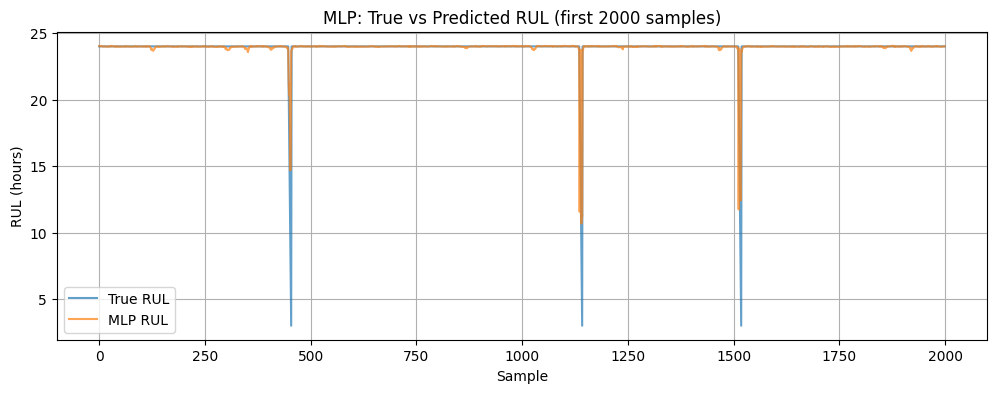

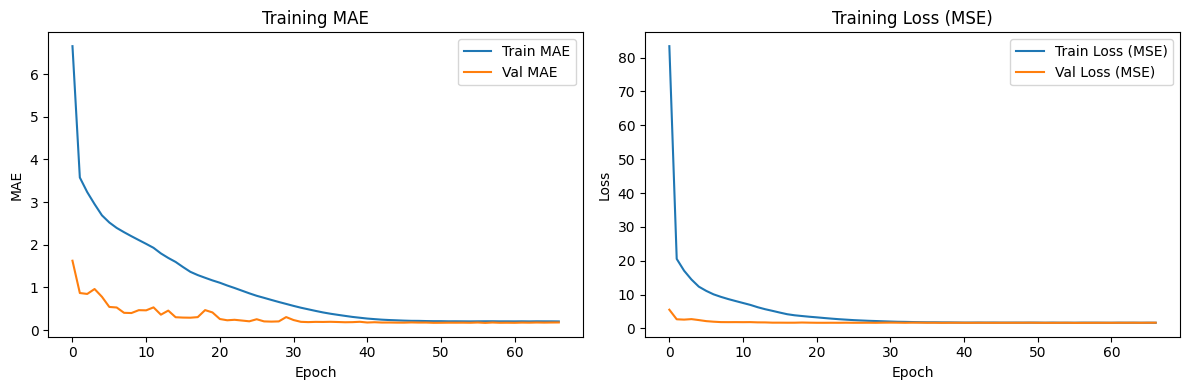

In [89]:
# Визуализация: График истинного RUL vs Предсказанного (для первых 2000 точек)
plt.figure(figsize=(12, 4))

plt.plot(y_val_final[:2000], label='True RUL', alpha=0.7)
plt.plot(y_pred_final[:2000], label=f'{best_config["model"]} RUL', alpha=0.7)
plt.title(f'{best_config["model"]}: True vs Predicted RUL (first 2000 samples)')
plt.xlabel('Sample')
plt.ylabel('RUL (hours)')
plt.legend()
plt.grid(True)
plt.show()

# Визуализация: График обучения
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(final_history['train_mae'], label='Train MAE')
plt.plot(final_history['val_mae'], label='Val MAE')
plt.title('Training MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(final_history['train_loss'], label='Train Loss (MSE)')
plt.plot(final_history['val_loss'], label='Val Loss (MSE)')
plt.title('Training Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [91]:
# Сохранение графиков
plots_dir = Path("/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Outputs/Plots")
plots_dir.mkdir(parents=True, exist_ok=True)

# Визуализация: График истинного RUL vs Предсказанного (для первых 2000 точек)
plt.figure(figsize=(12, 4))

plt.plot(y_val_final[:2000], label='True RUL', alpha=0.7)
plt.plot(y_pred_final[:2000], label=f'{best_config["model"]} RUL', alpha=0.7)
plt.title(f'{best_config["model"]}: True vs Predicted RUL (first 2000 samples)')
plt.xlabel('Sample')
plt.ylabel('RUL (hours)')
plt.legend()
plt.grid(True)
# Сохраняем и закрываем
plt.savefig(plots_dir / "rul_true_vs_pred.png", bbox_inches='tight', dpi=150)
plt.close()

# Визуализация: График обучения
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(final_history['train_mae'], label='Train MAE')
plt.plot(final_history['val_mae'], label='Val MAE')
plt.title('Training MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(final_history['train_loss'], label='Train Loss (MSE)')
plt.plot(final_history['val_loss'], label='Val Loss (MSE)')
plt.title('Training Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
# Сохраняем и закрываем
plt.savefig(plots_dir / "rul_training_history.png", bbox_inches='tight', dpi=150)
plt.close()

Сравнение с базовыми моделями.

In [83]:
# Базовый DLinear (без настройки)
y_pred_dlinear_base, _, _, _ = Evaluate(
    model_name="DLinear",
    X_train=X_train_final,
    y_train=y_train_final,
    X_val=X_val_final,
    y_val=y_val_final,
    params={"dropout": 0.1, "lr": 1e-3, "weight_decay": 1e-4},
    input_size=input_size,
    device=device,
    epochs=100
)

# Базовый MLP
y_pred_mlp_base, _, _, _ = Evaluate(
    model_name="MLP",
    X_train=X_train_final,
    y_train=y_train_final,
    X_val=X_val_final,
    y_val=y_val_final,
    params={"dropout": 0.3, "lr": 1e-3, "weight_decay": 1e-4, "hidden_size": 128},
    input_size=input_size,
    device=device,
    epochs=100
)

# Сбор всех моделей
models_preds = {
    "DLinear (default)": y_pred_dlinear_base,
    "MLP (default)": y_pred_mlp_base,
    f"Best ({best_config['model']})": y_pred_final
}

Train RUL 71: 100%|██████████| 913/913 [00:01<00:00, 878.10it/s]


In [ ]:
# Все метрики
def compute_all_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100  # Avoid div by zero
    return {"MAE": mae, "RMSE": rmse, "R^2": r2, "MAPE (%)": mape}

# Вывод сравнения
comparison = {}
for name, y_pred in models_preds.items():
    metrics = compute_all_metrics(y_val_final, y_pred)
    comparison[name] = metrics

# Таблица для удобства
comparison_df = pd.DataFrame(comparison).T
print("\nSummary Table:")
print(comparison_df.round(3))

comparison_df.to_csv("/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Outputs/Metrics/rul_regression_comparison_df.csv", index=False)


Summary Table:
                     MAE   RMSE    R^2  MAPE (%)
DLinear (default)  0.358  1.576  0.110     3.625
MLP (default)      0.180  1.278  0.415     2.290
Best (MLP)         0.171  1.284  0.409     2.264
